# Regressão Logística do Ponto de Vista de Deep Learning

Neste notebook será feita uma construção de um modelo de regressão logística do zero, em NumPy.

**Regressão Logística** é, primeiramente, uma ferramenta utilizada em estatística para modelar uma função que recebe os inputs que podem ser variáveis quantitativas ou qualitativas, e retornam uma classificação binária: SIM ou NÃO, 1 ou 0.

Em Machine Learning, regressão logística é um classificador que, a partir de um dataset de treino, é capaz de estimar se um elemento que não está no dataset é de uma classe 0 ou de uma classe 1.

Neste trabalho, você terá que:
1. Ler as funções fornecidas, entender o que elas fazem, e comentar na função, de acordo com seu entendimento e de forma compreensível;
2. Utilizá-las, obrigatoriamente, na construção do seu classificador de regressão logística;
3. Carregar o dataset fornecido, e separar em dois conjuntos, dataset de treino e dataset de teste;
4. Iniciar os pesos com zeros, para reproducibilidade do código;
5. A função de otimização deve rodar em menos de 10 segundos no Colab.

Neste trabalho você pode:
1. Deixar de usar algum dado que considerar desnecessário, desde que haja justificativa;
2. Fazer análises e visualizações de dados utilizando as técnicas aprendidas em Data Science.

A avaliação será dada pela acurácia num dataset de validação, que não está presente no dataset fornecido, **mas será o mesmo para todos**.

A nota será dada pela seguinte função:

$$ min((acc_{val} + 0.1)*10 - (penalidades), 10) $$

onde as penalidades serão de dois pontos para cada critério de exigência não cumprido, e $acc_{val}$ corresponde à acurácia obtida no dataset de validação.

Caso a função não funcione por algum motivo, a avaliação será subjetiva, com uma nota máxima de 4 pontos, considerando as penalidades e o progresso feito.

O foco da avaliação é o entendimento do processo de um perceptron simples, pois muito dos parâmetros trabalhados aqui são utilizados em diversas redes neurais profundas. Entender esses parâmetros fornecem um entendimento sobre o que mudar durante o treinamento de uma rede neural mais complexa.

## O Dataset

O dataset utilizado será um estudo feito em biópsias de células cancerígenas. Neste estudo foi feita a coleta de todos os dados, e então o diagnóstico de cada caso. Com isso, propôs-se que a regressão logística poderia construir um classificador que pode determinar se um tumor é BENIGNO ou MALIGNO.

Dados fornecidos:

**Diagnóstico**: se o tumor é Maligno (**M**) ou Benigno (**B**)

**Raio**: medida experimental do raio do tumor

**Textura**: medida experimental do desvio padrão das escalas de cinza

**Perímetro**: medida do tamanho do perímetro do núcleo do tumor

**Área**: medida experimental da área do tumor

**Suavidade**: medida de variações locais nos comprimentos do raio

**Compactação**: $perimetro^2/area-1$

**Concavidade**: severidade de porções côncavas do contorno

**Media das Concavidades**: media das porcoes côncavas

**Simetria** Medida da simetria radial

**Dimensão Fractal** Medida de suavidade da fronteira, é meio zoado de explicar

## Carregando o dataset

In [0]:
# Carregando o CSV:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Autenticação de usuário do google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = "https://drive.google.com/open?id=1ACaMpYwvFMBt_aBeg1xnk2dTU6dAduL6"

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1ACaMpYwvFMBt_aBeg1xnk2dTU6dAduL6


In [0]:
import pandas as pd

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
df.sample(5)

,diagnostico,raio_medio,textura_media,perimetro_medio,area_media,suavidade_media,compactacao_media,concavidade_media,media_concavidades,simetria_media,dimensao_fractal_media,erro_padrao_raio,erro_padrao_textura,erro_padrao_perimetro,erro_padrao_area,erro_padrao_suavidade,erro_padrao_compactacao,erro_padrao_concavidade,erro\n_padrao_concavidades,erro_padrao_simetria,erro_padrao_dimensao_fractal,pior_raio,pior_textura,pior_perimetro,pior_area,pior_suavidade,pior_compactacao,pior_concavidade,pior_media_concavidades,pior_simetria,pior_dimensao_fractal
303,M,25.73,17.46,174.20,2010.0,0.11490,0.23630,0.33680,0.19130,0.1956,0.06121,0.9948,0.8509,7222.0,153.10,0.006369,0.04243,0.04266,0.01508,0.02335,0.003385,33.13,23.58,229.3,3234.0,153.0000,0.5937,0.6451,0.2756,369.0000,0.08815
167,M,20.58,22.14,134.70,1290.0,0.09090,0.13480,164.00000,0.09561,0.1765,0.05024,0.8601,1.4800,7029.0,111.70,0.008124,0.03611,0.05489,0.02765,0.03176,0.002365,23.24,27.84,158.3,1656.0,0.1178,292.0000,0.3861,192.0000,0.2909,0.05865
435,B,14.87,20.21,96.12,680.9,0.09587,0.08345,0.06824,0.04951,0.1487,0.05748,0.2323,1636.0000,1596.0,21.84,0.005415,0.01371,0.02153,0.01183,0.01959,0.001812,16.01,28.48,103.9,783.6,0.1216,0.1388,0.1700,0.1017,0.2369,0.06599
151,M,16.46,20.11,109.30,832.9,0.09831,0.15560,0.17930,0.08866,0.1794,0.06323,0.3037,1284.0000,2482.0,31.59,0.006627,0.04094,0.05371,0.01813,0.01682,0.004584,17.79,28.45,123.5,981.2,0.1415,0.4667,0.5862,0.2035,0.3054,0.09519
320,M,22.01,21.90,147.20,1482.0,0.10630,0.19540,0.24480,0.15010,0.1824,0.06140,1008.0000,0.6999,7561.0,130.20,0.003978,0.02821,0.03576,0.01471,0.01518,0.003796,27.66,25.80,195.0,2227.0,0.1294,0.3885,0.4756,0.2432,0.2741,0.08574


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 31 columns):
diagnostico                     500 non-null object
raio_medio                      500 non-null float64
textura_media                   500 non-null float64
perimetro_medio                 500 non-null float64
area_media                      500 non-null float64
suavidade_media                 500 non-null float64
compactacao_media               500 non-null float64
concavidade_media               500 non-null float64
media_concavidades              500 non-null float64
simetria_media                  500 non-null float64
dimensao_fractal_media          500 non-null float64
erro_padrao_raio                500 non-null float64
erro_padrao_textura             500 non-null float64
erro_padrao_perimetro           500 non-null float64
erro_padrao_area                500 non-null float64
erro_padrao_suavidade           500 non-null float64
erro_padrao_compactacao         500 non-null flo

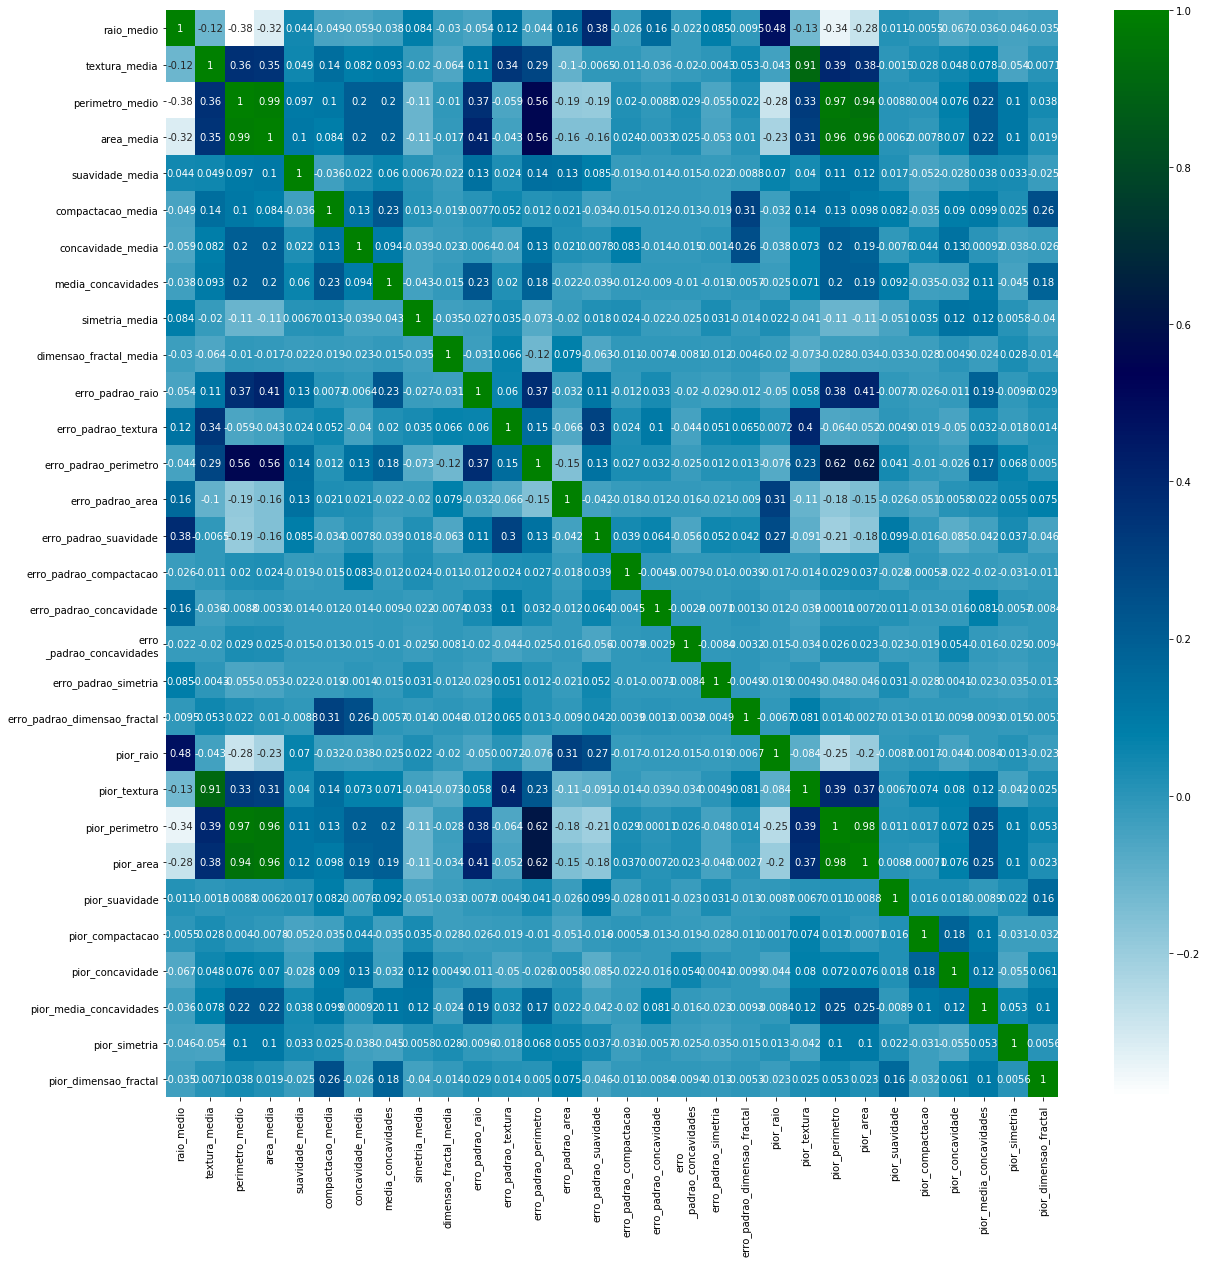

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(),annot=True,cmap='ocean_r',cbar=True)
plt.show()

In [0]:
sns.pairplot(data,hue = 'label',x_vars = features, y_vars = features)

In [0]:
# Retirada de parâmetros que possuem uma alta correlação com outro parâmetro, sendo escolhido o parâmetro com menor correlação com a label.
df = df.drop(['pior_area','erro_padrao_raio','erro_padrao_textura','erro_padrao_perimetro','erro_padrao_area','erro_padrao_suavidade','erro_padrao_compactacao','erro_padrao_concavidade'], axis=1)

## Primeira Etapa:

Deve se utilizada a seguinte função (comentando devidamente tudo o que estiver com informação faltando)

Detalhe: nem todas as funções utilizadas nesta função estão implementadas. Entretanto elas são auto-explicativas.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def propagacao(w, b, X, Y):
    """
    EXPLICAR BREVEMENTE O QUE ESSA FUNÇÃO FAZ NO CONTEXTO DE REGRESSÃO LOGÍSTICA

    Argumentos de entrada:
    w -- Representa o peso de cada parâmetro de entrada ao perceptron, ou seja, o valor específico de cada parâmetro que será multiplicado pelo valor do próprio parâmetro de entrada
    b -- Representa um valor de viés da propagação que deve ser aplicado a cada parâmetro de entrada do perceptron, ou seja, o mesmo valor será somado com cada parâmetro de entrada
    X -- dados de entrada com shape (n_features, numero de amostras)
    Y -- vetor de labels verdadeiras (1 se verdadeiro, 0 se falso) com shape (1, numero de amostras)

    Argumentos de saída:
    custo -- Representa o custo pelo cálculo da NLL
    dw    -- Representa o Gradiente do erro para os pesos de cada parâmetro
    db    -- Representa o Gradiente do viés para os parâmetros
    
    """
    
    m = X.shape[1]
    
    # Forward pass
    # Aqui são feitas as operações com os parâmetros de entrada do perceptron, sua ativação e seu cálculo de custo
    Z = np.dot(w.T, X) + b                                             # Vetor resultante da multiplicação dos parâmetros com seus respectivos pesos
    A = activation(Z)                                                  # Aplicação da função de ativação do perceptron a partir do vetor de parâmetros com seus respectivos pesos aplicados
    custo = -(1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))             # Aplicação da Negative Log-Likelihood
    
    
    # Cálculo dos Gradientes
    
    dw = (1/m)*np.dot(X,(A-Y).T)                                      # Shape dw: (n_features, 1)
    db = (1/m)*np.sum(A-Y)                                            # Shape db: (1)

    try: assert(dw.shape == w.shape)
    except AssertionError:
        print("shape de dw incorreto")
    try: assert(db.dtype == float)
    except AssertionError:
        print("tipo de db incorreto")
    cost = np.squeeze(custo)
    try: assert(custo.shape == ())
    except AssertionError:
        print("shape do custo incorreto")

    return dw, db, custo

## Escrever a seguir as outras funções auxiliares que irão fazer parte do seu código

A seguir será seu código em si. Implemente o restante do classificador de regressão logística (inicialização de variáveis, função de otimização por descida de gradiente, função de predict) e a função de execução do modelo em si no final, com entradas (X_treino, Y_treino, X_teste, Y_teste, n_iteracoes, taxa_aprendizagem).

Ao final, fazer o predict no dataset de teste e avaliar a acurácia do modelo.

In [0]:
def activation(Z):
  return 1/(1 + np.exp(-Z))

In [0]:
def initialize(n_features):

  weights = np.zeros(shape=(n_features, 1))
  bias = 0
  return weights, bias

In [0]:
def optimize(epochs, w, b, X, Y, learning_rate):

  for i in range(epochs):
    dw, db, _ = propagacao(w, b, X, Y)
    w = w - learning_rate*dw
    b = b - learning_rate*db
  return w, b

In [0]:
def predict(w, b, X):

  weighted_X = np.dot(w.T, X) + b

  activations = activation(weighted_X)
  activations[activations >= 0.5] = 1
  activations[activations < 0.5] = 0

  return activations

In [0]:
def model(X_treino, Y_treino, X_teste, Y_teste, taxa_aprendizagem, n_iteracoes):

  # Inicialização dos pesos e do viés com 0
  w, b = initialize(X_treino.shape[1])

  # Treino (Ajustes dos pesos e viés com base nos erros obtidos)
  Y_treino = Y_treino.values
  w_final, b_final = optimize(n_iteracoes, w, b, X_treino.T, Y_treino.T, taxa_aprendizagem)

  # A partir do peso e viés final obtido a partir da otimização, faz-se a predição para a parte de teste
  test_predictions = predict(w_final, b_final, X_teste.T)
  train_predictions = predict(w_final, b_final, X_treino.T)
  
  print('Train Accuracy:')
  print(sum(Y_train.values.T == train_predictions[0])/len(train_predictions[0]))
  print('Test Accuracy:')
  print(sum(Y_test.values.T == test_predictions[0])/len(test_predictions[0]))
  return w_final, b_final

In [0]:
# Codificação das labels para um valor numérico
label_codes = {
    'M' : 1,
    'B': 0
}

df.replace({'diagnostico': label_codes}, inplace=True)

In [0]:
df.describe()

,diagnostico,raio_medio,textura_media,perimetro_medio,area_media,suavidade_media,compactacao_media,concavidade_media,media_concavidades,simetria_media,dimensao_fractal_media,erro\n_padrao_concavidades,erro_padrao_simetria,erro_padrao_dimensao_fractal,pior_raio,pior_textura,pior_perimetro,pior_suavidade,pior_compactacao,pior_concavidade,pior_media_concavidades,pior_simetria,pior_dimensao_fractal
count,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.36400,669.148980,19.059800,91.874880,651.799400,4.428150,4.872327,7.351786,2.072826,17.448002,0.832224,0.075747,0.260232,0.015826,316.808260,25.435540,106.997320,11.860480,25.289016,24.843055,8.767991,30.303961,1.692652
std,0.48163,2360.174762,4.188681,23.981845,343.734273,21.318101,26.811476,34.426975,14.847422,54.624695,7.025674,0.836564,2.252756,0.268171,1654.936815,6.010986,32.954262,39.262711,97.361256,101.816815,40.087030,91.438495,12.742249
min,0.00000,7.760000,10.380000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.116700,0.049960,0.000000,0.007882,0.000895,7.930000,12.490000,50.410000,0.081250,0.034320,0.000000,0.000000,0.156500,0.055040
25%,0.00000,12.187500,16.020000,75.200000,420.875000,0.086600,0.066162,0.029837,0.020368,0.163400,0.058267,0.007783,0.015005,0.002246,13.187500,20.950000,84.147500,0.117575,0.154075,0.120475,0.065470,0.255600,0.071733
50%,0.00000,13.850000,18.610000,86.735000,552.950000,0.096620,0.096205,0.064905,0.033600,0.181700,0.061830,0.011000,0.018725,0.003195,15.140000,25.215000,97.665000,0.133650,0.231600,0.253900,0.101700,0.288650,0.080245
75%,1.00000,17.487500,21.540000,103.725000,775.375000,0.106225,0.132950,0.145850,0.077325,0.206000,0.066693,0.014933,0.023580,0.004562,19.827500,29.212500,124.475000,0.150525,0.375225,0.432300,0.166875,0.330925,0.092435
max,1.00000,9904.000000,39.280000,188.500000,2499.000000,123.000000,277.000000,281.000000,152.000000,304.000000,78.000000,12.000000,31.000000,6.000000,9981.000000,49.540000,229.300000,185.000000,1058.000000,1105.000000,291.000000,544.000000,124.000000


In [0]:
# Normalização dos dados dados do dataset
t2_nomalized = df.drop(['diagnostico'],axis = 1)

normalized_df=(t2_nomalized-t2_nomalized.mean())/t2_nomalized.std()

In [0]:
normalized_df.describe()

,raio_medio,textura_media,perimetro_medio,area_media,suavidade_media,compactacao_media,concavidade_media,media_concavidades,simetria_media,dimensao_fractal_media,erro\n_padrao_concavidades,erro_padrao_simetria,erro_padrao_dimensao_fractal,pior_raio,pior_textura,pior_perimetro,pior_suavidade,pior_compactacao,pior_concavidade,pior_media_concavidades,pior_simetria,pior_dimensao_fractal
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,7.693846e-17,-3.211653e-15,-2.597922e-15,-9.041656e-16,8.304468e-17,-8.104628e-17,7.677192e-17,-1.098566e-16,-3.513856e-16,5.012657e-17,2.778333e-17,1.994516e-16,-1.605660e-17,-7.105427e-18,2.938538e-15,-5.502265e-16,-7.238654e-17,-4.363176e-17,1.404432e-16,2.398637e-16,1.142419e-16,6.106227e-19
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.802288e-01,-2.072204e+00,-2.005053e+00,-1.478757e+00,-2.052491e-01,-1.810026e-01,-2.135473e-01,-1.396084e-01,-3.172796e-01,-1.113436e-01,-9.054548e-02,-1.120183e-01,-5.567846e-02,-1.866405e-01,-2.153647e+00,-1.717147e+00,-3.000106e-01,-2.593916e-01,-2.439976e-01,-2.187239e-01,-3.297021e-01,-1.285183e-01
25%,-2.783529e-01,-7.257177e-01,-6.953126e-01,-6.718108e-01,-2.036556e-01,-1.792577e-01,-2.126806e-01,-1.382367e-01,-3.164247e-01,-1.101612e-01,-8.124194e-02,-1.088564e-01,-5.063988e-02,-1.834637e-01,-7.462236e-01,-6.933798e-01,-2.990854e-01,-2.581616e-01,-2.428143e-01,-2.170907e-01,-3.286183e-01,-1.272083e-01
50%,-2.776485e-01,-1.073846e-01,-2.143238e-01,-2.875750e-01,-2.031855e-01,-1.781372e-01,-2.116620e-01,-1.373454e-01,-3.160897e-01,-1.096541e-01,-7.739645e-02,-1.072050e-01,-4.709923e-02,-1.822839e-01,-3.668949e-02,-2.831901e-01,-2.986760e-01,-2.573654e-01,-2.415039e-01,-2.161869e-01,-3.282568e-01,-1.265402e-01
75%,-2.761073e-01,5.921196e-01,4.941288e-01,3.595091e-01,-2.027350e-01,-1.767667e-01,-2.093108e-01,-1.344005e-01,-3.156448e-01,-1.089620e-01,-7.269567e-02,-1.050499e-01,-4.200173e-02,-1.794514e-01,6.283428e-01,5.303618e-01,-2.982462e-01,-2.558902e-01,-2.397517e-01,-2.145611e-01,-3.277945e-01,-1.255836e-01
max,3.912783e+00,4.827343e+00,4.029095e+00,5.373920e+00,5.562027e+00,1.014967e+01,7.948657e+00,1.009786e+01,5.245832e+00,1.098368e+01,1.425385e+01,1.364540e+01,2.231478e+01,5.839614e+00,4.010067e+00,3.711286e+00,4.409770e+00,1.060700e+01,1.060883e+01,7.040482e+00,5.617941e+00,9.598568e+00


## Modelo e teste para os dados **não** normalizados

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(['diagnostico'],axis = 1),df['diagnostico'], test_size = 0.30, random_state = 42)

w_final, b_final = model(X_train, Y_train, X_test, Y_test, 0.0001, 20000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Train Accuracy:
0.9314285714285714
Test Accuracy:
0.92


## Modelo e teste para os dados **normalizados**

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(normalized_df,df['diagnostico'], test_size = 0.30, random_state = 42)

w_final, b_final = model(X_train, Y_train, X_test, Y_test, 0.0001, 20000)

Train Accuracy:
0.9314285714285714
Test Accuracy:
0.92
